# Bad signal classifier

**This notebook aims to classify electrophysiology signals regarding their quality by using machine learning techniques.**<br />
*Please, also find my live presentation on YouTube (in french): https://youtu.be/-pawzPjUb9U?t=2649*

**Problem:**
<ul>
    <li>When first connecting electrodes to plants, sometimes electrodes are not correctly inserted and this leads to poor quality recordings. We manually review all experimental data after 24 and 48 hours to check on signal quality and then recommend to users to reinsert electrodes if necessary.</li>
</ul>

**An ideal solution:**
<ul>
    <li>Automating the task of identifying poor electrode placements and ensure this problem is diagnosed as early as possible.</li>
</ul>

**Raw data:**
<ul>
    <li>Records from 48 plant traces between September 28th, 2020 and March 9th, 2021.</li>
    <li>Signals are recorded at 256 samples per second. Vivent resampled the data to 1Hz (the value for one second is the mean of the 256 samples).</li>
    <li>The data is stored in 1970 distinct parquet files. Each file corresponds to one day of one plant recording.</li>
    <li>The data is unlabeled, which means good and bad signals have never been classified yet.</li>
</ul>

**Upstream preprocessing of this notebook:**
<ul>
    <li>Labeling signals on a daily basis (1 day => 1 signal => 1 label).</li>
    <li>Extracting features from the signals. Sliding window of 1 hour over the dataset to compute mean, variance and standard deviation for each period.</li>
    <li>Filling NAN values with the constant value 0</li>
    <li>Removing 162 over 1970 uncomplete signals (records which do not cover a whole day)</li>
    <li>Store the resulting dataset into a CSV file.</li>
</ul>

**Resulting data:**
<ul>
    <li>A CSV file of 1808 rows 73 columns (24 hours * 3 features).</li>
</ul>

**Variables:**
<ul>
    <li>hour_mean_voltage: mean of the recorded voltage in the time window (in millivolt mV)</li>
    <li>hour_var_voltage: variance of the recorded voltage in the time window (in millivolt mV)</li>
    <li>hour_std_voltage: standard deviation of the recorded voltage in the time window (in millivolt mV)</li>
</ul>

**Target**:
<ul>
    <li>label (<strong>0</strong>: good signal, <strong>1</strong>: bad signal)</li>
</ul>

**Machine Learning models:**
<ul>
    <li>This notebook explores different model classifiers like KNN, SVM, Random Forest, Gradient Boosting or AdaBoost. Pipelines have been created so that the notebook may be easily replicable with other models or data sources.</li>
</ul>

**Performance metrics:**
<ul>
    <li><strong>Recall:</strong> the main objective is to avoid false negative, which means to classify a bad signal as a good signal (recall = bad signals predicted correctly out of the real number of bad signals).</li>
    <li><strong>F1-Score:</strong> Our classes are a little imbalanced, which may slightly affect our accuracy indicator.</li>
</ul>

**Objectives:**
<ul>
    <li>Recall: 0.85 minimum</li>
    <li>F1-Score: 0.80 minimum</li>
</ul>

*N.B: Many preprocessing techniques have been tried upstream of this notebook, like different time windows, imputation methods or extracted features. The one that is presented in this document showed the best result on this dataset, but may differ if using on other data sources.*

In [1]:
# import required packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline

# import dataset and read 5 first lines
signals = pd.read_csv("daily_labelled_signal.csv")
signals.drop("Unnamed: 0", axis=1, inplace=True)
signals.head()

,hour_0_mean_voltage,hour_0_var_voltage,hour_0_std_voltage,hour_1_mean_voltage,hour_1_var_voltage,hour_1_std_voltage,hour_2_mean_voltage,hour_2_var_voltage,hour_2_std_voltage,hour_3_mean_voltage,...,hour_21_mean_voltage,hour_21_var_voltage,hour_21_std_voltage,hour_22_mean_voltage,hour_22_var_voltage,hour_22_std_voltage,hour_23_mean_voltage,hour_23_var_voltage,hour_23_std_voltage,label
0,-47.787045,1.063986,1.031497,-50.717412,0.756128,0.869556,-51.234689,1.870843,1.367787,-48.202051,...,-44.282997,3.100434,1.760805,-47.308217,3.817532,1.953851,-51.131585,1.542069,1.241801,0
1,-55.894768,2.685834,1.638851,-62.205159,3.114033,1.764662,-70.236736,13.715746,3.703478,-74.266392,...,-49.449775,1.309717,1.144429,-48.900174,0.356781,0.597312,-56.246969,6.822396,2.611972,0
2,-68.028353,22.181370,4.709710,-71.225587,0.155337,0.394128,-68.674252,1.209892,1.099951,-65.899395,...,-58.599430,0.709702,0.842438,-61.441225,3.244341,1.801205,-64.538278,1.929744,1.389152,0
3,-66.015989,0.438377,0.662101,-69.136429,0.965956,0.982831,-68.164381,0.312113,0.558670,-66.969166,...,-56.296071,1.568237,1.252293,-58.777049,0.493819,0.702723,-59.664700,0.134079,0.366167,0
4,-61.014034,1.736357,1.317709,-61.661189,0.168476,0.410458,-61.129376,0.390795,0.625136,-62.453524,...,-59.354515,0.200694,0.447989,-59.447597,0.143270,0.378510,-59.655444,0.057494,0.239780,0


In [2]:
# Define functions to measure model performance
def model_evaluation(ml_model):
    """
    This function fits a simple classification model to the train data and measures its performance on the test set.
    Several metrics are returned like the classification report, the confusion matrix and the learning curve of the model.
    """
    ml_model.fit(X_train, y_train)
    y_pred = ml_model.predict(X_test)
    print(f"Score on train set: {ml_model.score(X_train, y_train)} | Score on test set: {ml_model.score(X_test, y_test)}")
    print("\n")
    print(classification_report(y_test, y_pred))

    N, train_score, val_score = learning_curve(ml_model, X_train, y_train, cv=5, scoring="recall", 
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False, sharex=False)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", ax=axes[0])
    axes[0].set_title("Confusion matrix")
    axes[1].plot(N, train_score.mean(axis=1))
    axes[1].plot(N, val_score.mean(axis=1))
    axes[1].set_title("Learning curve")
    axes[1].set_xlabel('train_sizes')
    axes[1].set_ylabel('scores')
    axes[1].set_ylim(0.65, 1.0)
    axes[1].legend(["train", "validation"])
    plt.show()

def grid_evaluation(grid_model):
    """
    This function accepts a classification model optimized using GridSearchCV.
    It fits the model to the train data and measures its performance on the test set.
    Several metrics are returned like the classification report, the confusion matrix and the learning curve of the model.
    """
    grid_model.fit(X_train, y_train)
    y_pred = grid_model.predict(X_test)
    print(f"Best parameters : {grid_model.best_params_} | Score on train set: {grid_model.score(X_train, y_train)} | Score on test set: {grid_model.score(X_test, y_test)}")
    print("\n")
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(grid_model.best_estimator_, X_train, y_train, cv=5, scoring="recall", 
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False, sharex=False)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", ax=axes[0])
    axes[0].set_title("Confusion matrix")
    axes[1].plot(N, train_score.mean(axis=1))
    axes[1].plot(N, val_score.mean(axis=1))
    axes[1].set_title("Learning curve")
    axes[1].set_xlabel('train_sizes')
    axes[1].set_ylabel('scores')
    axes[1].set_ylim(0.65, 1.0)
    axes[1].legend(["train", "validation"])
    plt.show()

### Data Exploration

Label distribution (in %):
1    59.13
0    40.87
Name: label, dtype: float64


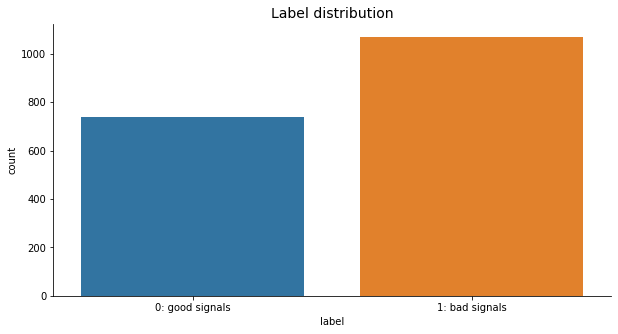

In [3]:
print(f"Label distribution (in %):\n{round(signals['label'].value_counts() * 100 / signals.shape[0], 2)}")

# plot number of bad and good signals
plt.figure(figsize=(10,5))
sns.countplot(x="label", data=signals)
sns.despine()
plt.title("Label distribution", size=14)
plt.xticks(ticks=[0, 1], labels=["0: good signals", "1: bad signals"])
plt.show()

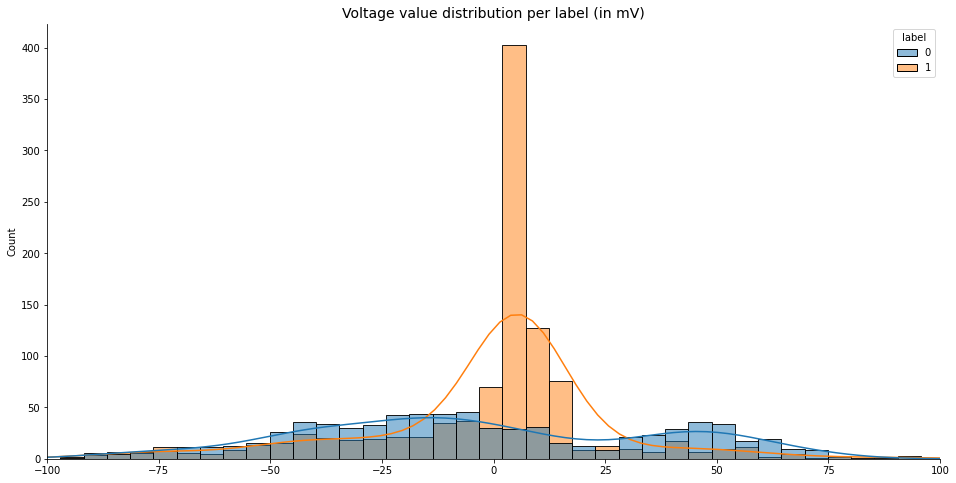

In [4]:
# Plot voltage value distribution per label
mean_voltage_columns = [col for col in signals.columns if col.endswith("_mean_voltage")]

plt.figure(figsize=(16,8))
sns.histplot(x=signals[mean_voltage_columns].mean(axis=1), hue=signals["label"], kde=True)
sns.despine()
plt.xlim([-100, 100])
plt.title("Voltage value distribution per label (in mV)", size=14)
plt.show()

### Data Preprocessing & Pipeline Development

In [5]:
# Define the features list and target variable
features_list = list(signals.columns)
features_list.remove("label")
target_variable = "label"

# Set features and target variable to numpy arrays
X = signals[features_list].to_numpy()
y = signals[target_variable].to_numpy()

print(X.shape)
print(y.shape)

(1808, 72)
(1808,)


In [6]:
# Divide dataset Train set & Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
# Set a scaler to normalize X
scaler = StandardScaler()

In [8]:
# Initialize processing and machine learning pipelines
logreg = make_pipeline(scaler, LogisticRegression(random_state=0, max_iter=200))
knn = make_pipeline(scaler, KNeighborsClassifier())
svm = make_pipeline(scaler, SVC(random_state=0))
adaboost = make_pipeline(scaler, AdaBoostClassifier(random_state=0))
random_forest = make_pipeline(RandomForestClassifier(random_state=0))
gbc = make_pipeline(scaler, GradientBoostingClassifier(random_state=0))

# Store pipelines in dict
dict_of_models = {
    "LogReg" : logreg,
    "KNN" : knn,
    "SVM" : svm,
    "AdaBoost" : adaboost,
    "RandomForest" : random_forest,
    "GBC" : gbc
}

### Machine Learning

#### Implement simple classification models

----------------------------------------------------------------
LogReg
Score on train set: 0.7697095435684648 | Score on test set: 0.7541436464088398


              precision    recall  f1-score   support

           0       0.73      0.66      0.70       154
           1       0.77      0.82      0.79       208

    accuracy                           0.75       362
   macro avg       0.75      0.74      0.74       362
weighted avg       0.75      0.75      0.75       362



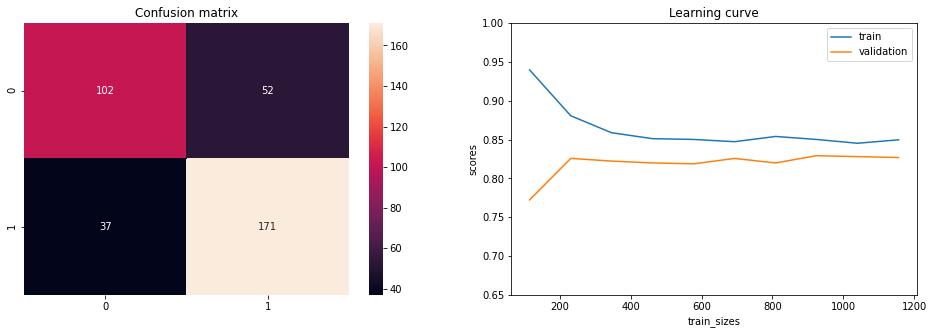

----------------------------------------------------------------
KNN
Score on train set: 0.8852005532503457 | Score on test set: 0.8425414364640884


              precision    recall  f1-score   support

           0       0.77      0.90      0.83       154
           1       0.92      0.80      0.85       208

    accuracy                           0.84       362
   macro avg       0.84      0.85      0.84       362
weighted avg       0.85      0.84      0.84       362



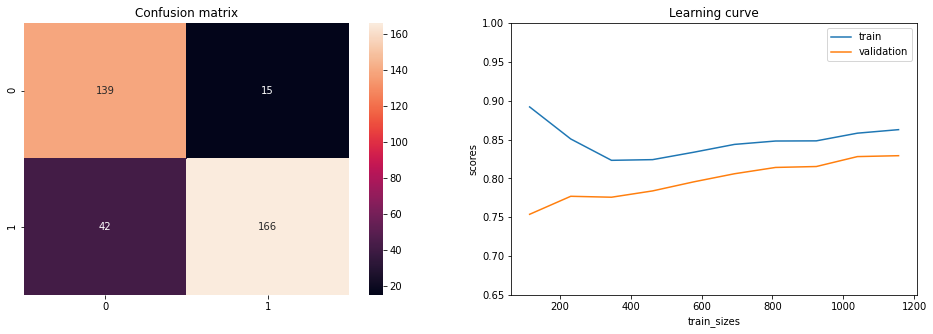

----------------------------------------------------------------
SVM
Score on train set: 0.8360995850622407 | Score on test set: 0.8066298342541437


              precision    recall  f1-score   support

           0       0.77      0.79      0.78       154
           1       0.84      0.82      0.83       208

    accuracy                           0.81       362
   macro avg       0.80      0.80      0.80       362
weighted avg       0.81      0.81      0.81       362



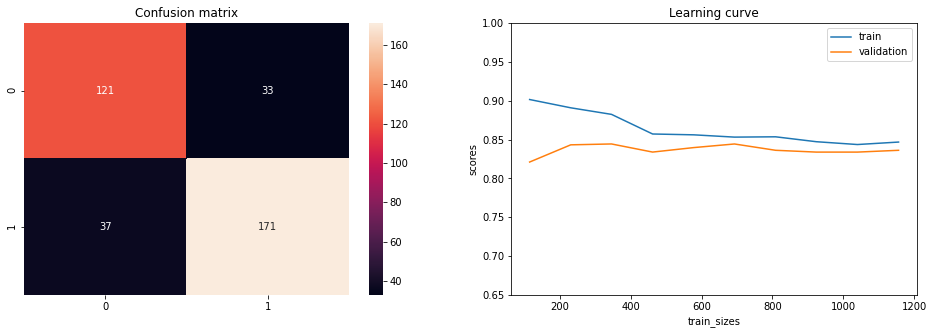

----------------------------------------------------------------
AdaBoost
Score on train set: 0.8727524204702628 | Score on test set: 0.8204419889502762


              precision    recall  f1-score   support

           0       0.78      0.80      0.79       154
           1       0.85      0.84      0.84       208

    accuracy                           0.82       362
   macro avg       0.82      0.82      0.82       362
weighted avg       0.82      0.82      0.82       362



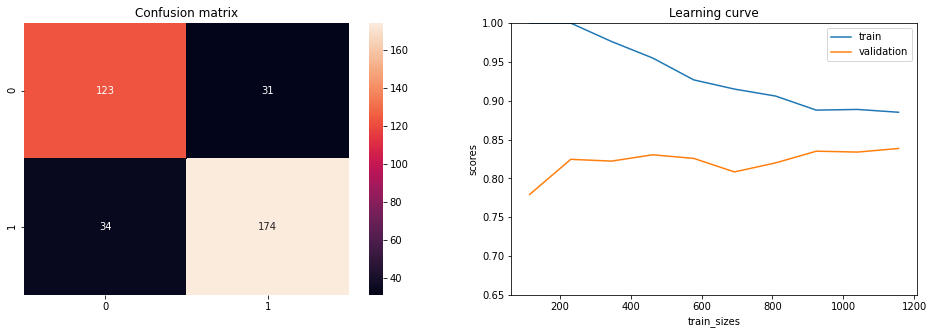

----------------------------------------------------------------
RandomForest
Score on train set: 1.0 | Score on test set: 0.8729281767955801


              precision    recall  f1-score   support

           0       0.81      0.91      0.86       154
           1       0.93      0.85      0.88       208

    accuracy                           0.87       362
   macro avg       0.87      0.88      0.87       362
weighted avg       0.88      0.87      0.87       362



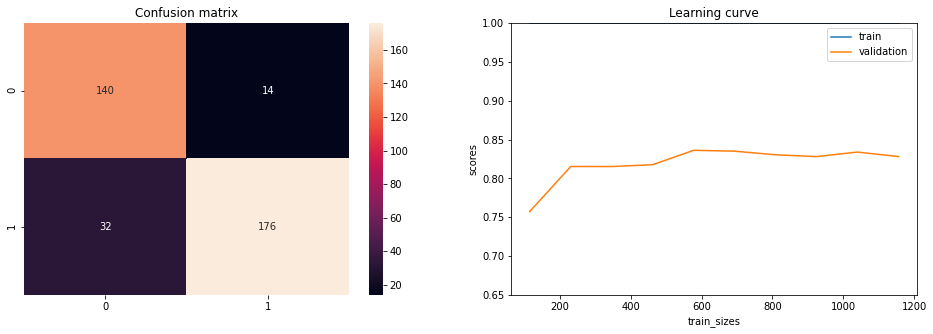

----------------------------------------------------------------
GBC
Score on train set: 0.9536652835408023 | Score on test set: 0.850828729281768


              precision    recall  f1-score   support

           0       0.80      0.86      0.83       154
           1       0.89      0.85      0.87       208

    accuracy                           0.85       362
   macro avg       0.85      0.85      0.85       362
weighted avg       0.85      0.85      0.85       362



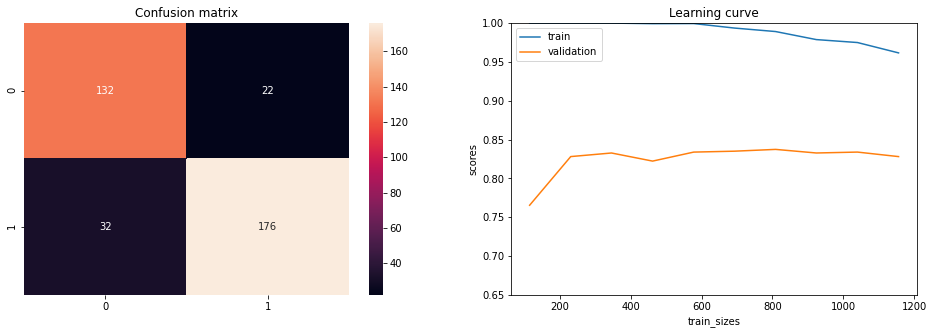

Wall time: 1min 52s


In [9]:
%%time
# Iterate over simple models (non-optimized)
for name, model in dict_of_models.items():
    print("----------------------------------------------------------------")
    print(name)
    model_evaluation(model)

#### Parameter optimization

In [10]:
# Initialize parameters to optimize ML models
params = {
    "SVM" : {"svc__C" : [1, 10, 100, 1000]},
    "KNN" : {"kneighborsclassifier__n_neighbors" : np.arange(1, 11)},
    "LogReg" : {
        "logisticregression__penalty" : ["l1", "l2"],
        "logisticregression__C" : np.logspace(-4, 4, 20),
        "logisticregression__solver" : ["liblinear"]
    },
    "GBC" : {"gradientboostingclassifier__n_estimators" : np.arange(10, 100, 10)},
    "RandomForest" : {"randomforestclassifier__n_estimators" : np.arange(10, 200, 10)},
    "AdaBoost" : {
        "adaboostclassifier__n_estimators" : np.arange(10, 200, 10),
        "adaboostclassifier__learning_rate" : [0.1, 1]
    }
}

In [11]:
# Store optimized models in dictionary
dict_of_grids = {
    "KNN" : GridSearchCV(knn, params["KNN"], cv=5),
    "SVM" : GridSearchCV(svm, params["SVM"], cv=5),
    "AdaBoost" : GridSearchCV(adaboost, params["AdaBoost"], cv=5),
    "RandomForest" : GridSearchCV(random_forest, params["RandomForest"], cv=5),
    "GBC" : GridSearchCV(gbc, params["GBC"], cv=5),
    # "LogReg" : GridSearchCV(logreg, params["LogReg"], cv=5),
    # Exclude logreg because of weak recall and too many iterations for this model
}

----------------------------------------------------------------
KNN
Best parameters : {'kneighborsclassifier__n_neighbors': 5} | Score on train set: 0.8852005532503457 | Score on test set: 0.8425414364640884


              precision    recall  f1-score   support

           0       0.77      0.90      0.83       154
           1       0.92      0.80      0.85       208

    accuracy                           0.84       362
   macro avg       0.84      0.85      0.84       362
weighted avg       0.85      0.84      0.84       362



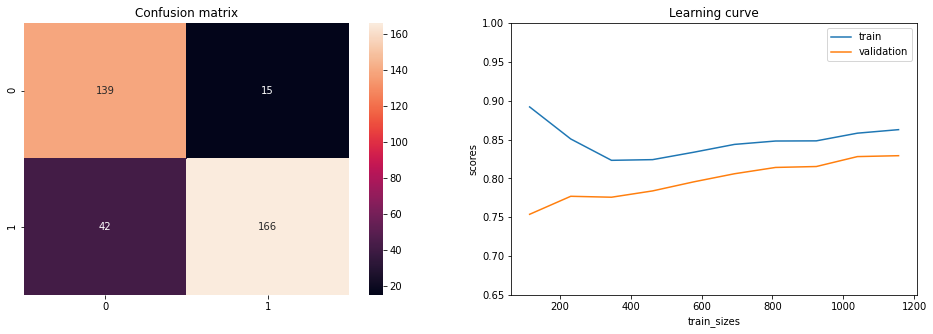

----------------------------------------------------------------
SVM
Best parameters : {'svc__C': 10} | Score on train set: 0.8796680497925311 | Score on test set: 0.8425414364640884


              precision    recall  f1-score   support

           0       0.78      0.88      0.83       154
           1       0.90      0.82      0.86       208

    accuracy                           0.84       362
   macro avg       0.84      0.85      0.84       362
weighted avg       0.85      0.84      0.84       362



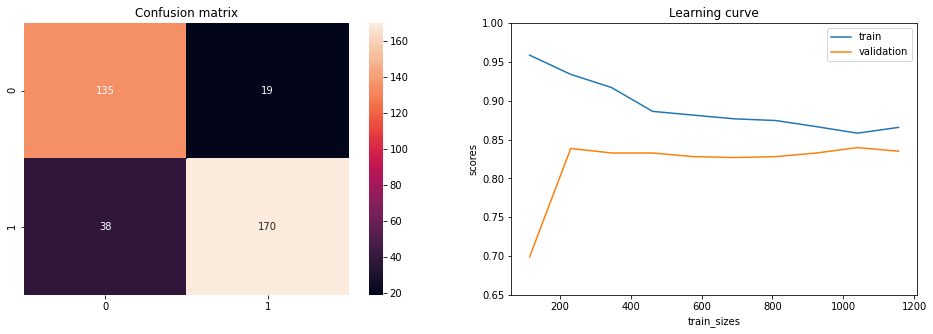

----------------------------------------------------------------
AdaBoost
Best parameters : {'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 160} | Score on train set: 0.8616874135546335 | Score on test set: 0.8204419889502762


              precision    recall  f1-score   support

           0       0.77      0.82      0.80       154
           1       0.86      0.82      0.84       208

    accuracy                           0.82       362
   macro avg       0.82      0.82      0.82       362
weighted avg       0.82      0.82      0.82       362



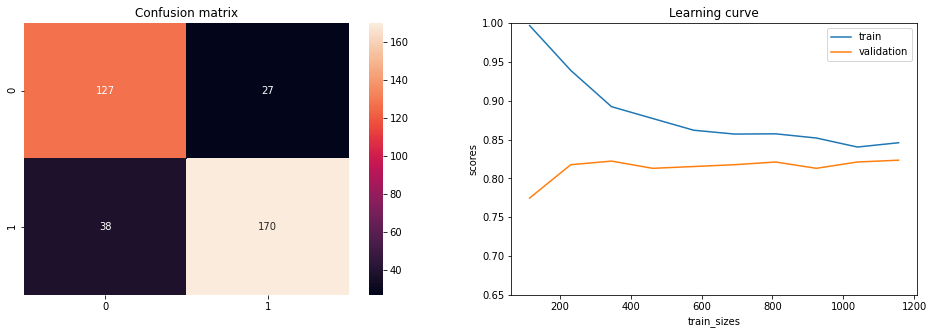

----------------------------------------------------------------
RandomForest
Best parameters : {'randomforestclassifier__n_estimators': 170} | Score on train set: 1.0 | Score on test set: 0.8784530386740331


              precision    recall  f1-score   support

           0       0.82      0.91      0.86       154
           1       0.93      0.86      0.89       208

    accuracy                           0.88       362
   macro avg       0.88      0.88      0.88       362
weighted avg       0.88      0.88      0.88       362



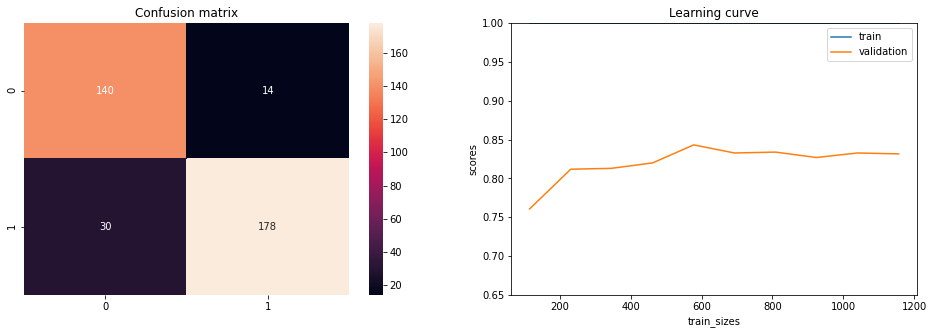

----------------------------------------------------------------
GBC
Best parameters : {'gradientboostingclassifier__n_estimators': 60} | Score on train set: 0.9287690179806363 | Score on test set: 0.8646408839779005


              precision    recall  f1-score   support

           0       0.81      0.88      0.85       154
           1       0.91      0.85      0.88       208

    accuracy                           0.86       362
   macro avg       0.86      0.87      0.86       362
weighted avg       0.87      0.86      0.87       362



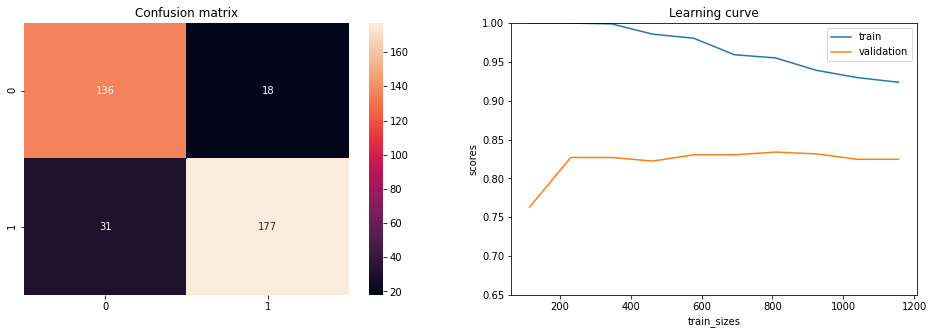

Wall time: 7min 47s


In [12]:
%%time
for name, grid in dict_of_grids.items():
    print("----------------------------------------------------------------")
    print(name)
    grid_evaluation(grid)

## Performance analysis

**KNN:**
<ul>
    <li>Recall: 0.85</li>
    <li>F1_score: 0.84</li>
    <li>Observation: Very light overfitting. The validation curve is constantly growing, it may perform even better with more data.</li>
</ul>

**SVM:**
<ul>
    <li>Recall: 0.85</li>
    <li>F1_score: 0.84</li>
    <li>Observation: No overfitting. The test and validation curves are joining together. But we may pay attention to larget datasets which may lead to overfitting. Keep SVM for small datasets.</li>
</ul>

**AdaBoost:**
<ul>
    <li>Recall: 0.82</li>
    <li>F1_score: 0.82</li>
    <li>Observation: No overfitting. The test and validation curves are joining together. But the validation curve seems to remain flat independently of data volume. It may be hard to get better performance.</li>
</ul>

**Random Forest:**
<ul>
    <li>Recall: 0.88</li>
    <li>F1_score: 0.88</li>
    <li>Observation: Best performance, but train score = 1 to be explored.</li>
</ul>

**Gradient Boosting**
<ul>
    <li>Recall: 0.87</li>
    <li>F1_score: 0.86</li>
    <li>Observation: Very interesting performance. Nevertheless, it suffers a bit of overfitting, and adding data does not seem to affect its prediction power positively. Model to be used on small dataset. Try other parameters to reduce overfitting.</li>
</ul>

### Cross-plants Validation

Let's ensure that train set is taking 80% of the data of each plant trace, and the test set 20% of each.

In [13]:
# import dataset and read 5 first lines
signals = pd.read_csv("plantid-daily-labelled-signal.csv")
signals.drop("Unnamed: 0", axis=1, inplace=True)
signals.head()

,hour_0_mean_voltage,hour_0_var_voltage,hour_0_std_voltage,hour_1_mean_voltage,hour_1_var_voltage,hour_1_std_voltage,hour_2_mean_voltage,hour_2_var_voltage,hour_2_std_voltage,hour_3_mean_voltage,...,hour_21_var_voltage,hour_21_std_voltage,hour_22_mean_voltage,hour_22_var_voltage,hour_22_std_voltage,hour_23_mean_voltage,hour_23_var_voltage,hour_23_std_voltage,label,plant_id
0,-47.787045,1.063986,1.031497,-50.717412,0.756128,0.869556,-51.234689,1.870843,1.367787,-48.202051,...,3.100434,1.760805,-47.308217,3.817532,1.953851,-51.131585,1.542069,1.241801,0,Plant 1
1,-55.894768,2.685834,1.638851,-62.205159,3.114033,1.764662,-70.236736,13.715746,3.703478,-74.266392,...,1.309717,1.144429,-48.900174,0.356781,0.597312,-56.246969,6.822396,2.611972,0,Plant 1
2,-68.028353,22.181370,4.709710,-71.225587,0.155337,0.394128,-68.674252,1.209892,1.099951,-65.899395,...,0.709702,0.842438,-61.441225,3.244341,1.801205,-64.538278,1.929744,1.389152,0,Plant 1
3,-66.015989,0.438377,0.662101,-69.136429,0.965956,0.982831,-68.164381,0.312113,0.558670,-66.969166,...,1.568237,1.252293,-58.777049,0.493819,0.702723,-59.664700,0.134079,0.366167,0,Plant 1
4,-61.014034,1.736357,1.317709,-61.661189,0.168476,0.410458,-61.129376,0.390795,0.625136,-62.453524,...,0.200694,0.447989,-59.447597,0.143270,0.378510,-59.655444,0.057494,0.239780,0,Plant 1


In [14]:
plant_ids = [plant_id for plant_id in signals["plant_id"].unique()]

In [15]:
%%time
# create lists to store numpy array for each plant
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

target_variable = "label"

# train test split on each plant id
for plant_id in plant_ids:
    df = signals[signals["plant_id"] == plant_id]
    features_without_id = list(signals.columns)
    features_without_id.remove("plant_id")
    features_without_id.remove("label")
    X_sample = df[features_without_id].to_numpy()
    y_sample = df[target_variable].to_numpy()
    X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=0)
    X_train_list.append(X_train_sample)
    X_test_list.append(X_test_sample)
    y_train_list.append(y_train_sample)
    y_test_list.append(y_test_sample)

# concatenate data in train and test numpy arrays
X_train_set = np.concatenate(X_train_list)
y_train_set = np.concatenate(y_train_list)
X_test_set = np.concatenate(X_test_list)
y_test_set = np.concatenate(y_test_list)

# convert arrays to dataframe for shuffling
train_df = pd.DataFrame(data=X_train_set)
train_df["label"] = y_train_set
train_df = train_df.sample(frac=1, random_state=2).reset_index(drop=True)

test_df = pd.DataFrame(data=X_test_set)
test_df["label"] = y_test_set
test_df = test_df.sample(frac=1).reset_index(drop=True)

# reconvert the shuffled data into numpy arrays
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1423, 72)
(385, 72)
(1423,)
(385,)
Wall time: 120 ms


----------------------------------------------------------------
KNN
Best parameters : {'kneighborsclassifier__n_neighbors': 4} | Score on train set: 0.8805340829234013 | Score on test set: 0.8753246753246753


              precision    recall  f1-score   support

           0       0.79      0.94      0.86       155
           1       0.95      0.83      0.89       230

    accuracy                           0.88       385
   macro avg       0.87      0.89      0.87       385
weighted avg       0.89      0.88      0.88       385



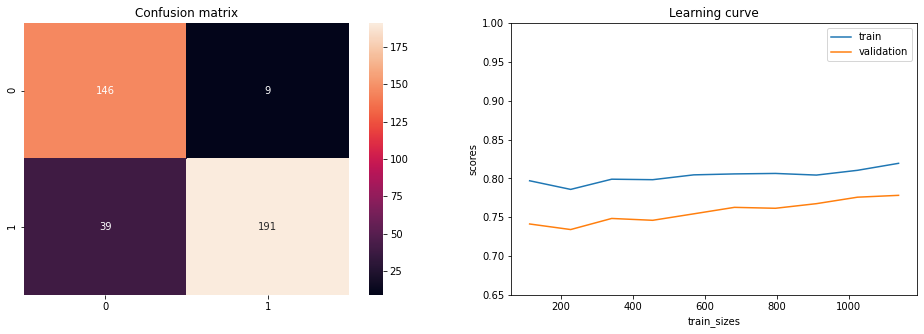

----------------------------------------------------------------
SVM
Best parameters : {'svc__C': 100} | Score on train set: 0.9262122276879832 | Score on test set: 0.8155844155844156


              precision    recall  f1-score   support

           0       0.76      0.79      0.77       155
           1       0.85      0.83      0.84       230

    accuracy                           0.82       385
   macro avg       0.81      0.81      0.81       385
weighted avg       0.82      0.82      0.82       385



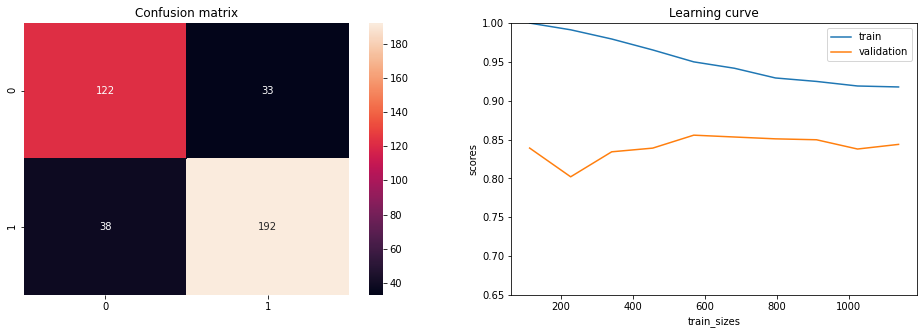

----------------------------------------------------------------
AdaBoost
Best parameters : {'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 190} | Score on train set: 0.8699929725931131 | Score on test set: 0.8181818181818182


              precision    recall  f1-score   support

           0       0.76      0.80      0.78       155
           1       0.86      0.83      0.85       230

    accuracy                           0.82       385
   macro avg       0.81      0.82      0.81       385
weighted avg       0.82      0.82      0.82       385



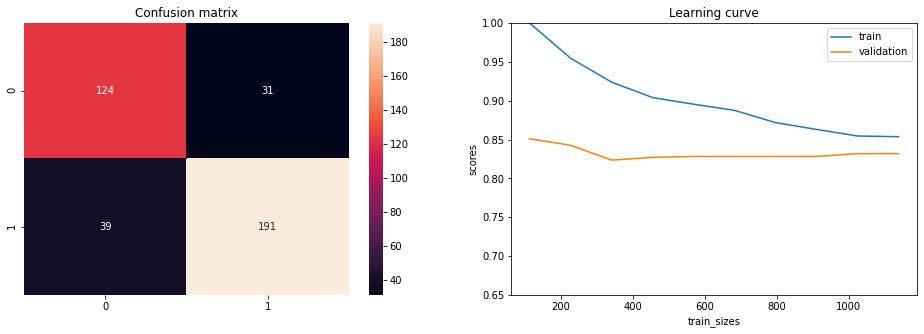

----------------------------------------------------------------
RandomForest
Best parameters : {'randomforestclassifier__n_estimators': 190} | Score on train set: 1.0 | Score on test set: 0.8649350649350649


              precision    recall  f1-score   support

           0       0.80      0.88      0.84       155
           1       0.92      0.85      0.88       230

    accuracy                           0.86       385
   macro avg       0.86      0.87      0.86       385
weighted avg       0.87      0.86      0.87       385



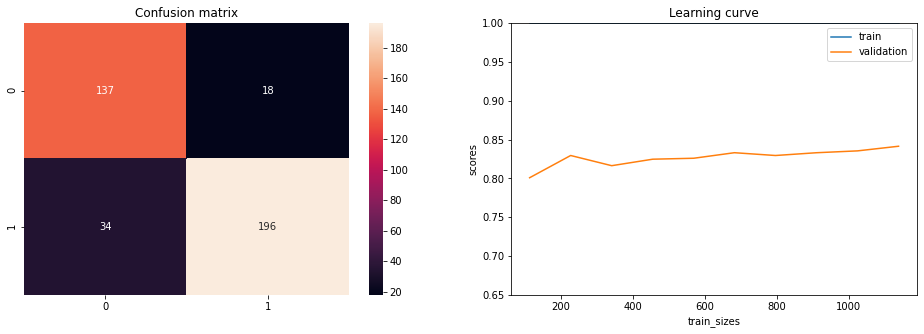

----------------------------------------------------------------
GBC
Best parameters : {'gradientboostingclassifier__n_estimators': 60} | Score on train set: 0.9318341531974701 | Score on test set: 0.8545454545454545


              precision    recall  f1-score   support

           0       0.79      0.87      0.83       155
           1       0.91      0.84      0.87       230

    accuracy                           0.85       385
   macro avg       0.85      0.86      0.85       385
weighted avg       0.86      0.85      0.86       385



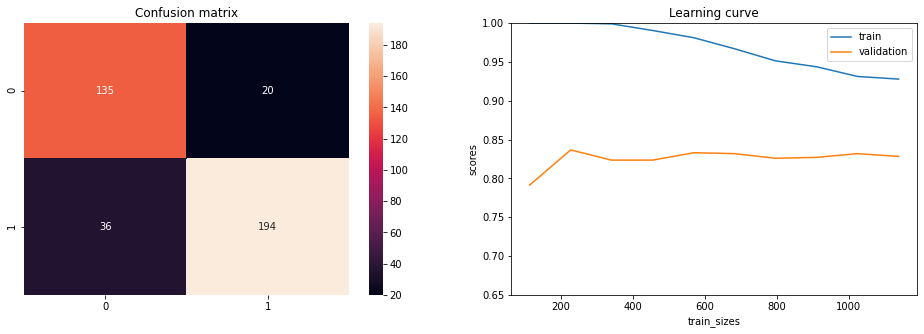

Wall time: 8min 17s


In [16]:
%%time
for name, grid in dict_of_grids.items():
    print("----------------------------------------------------------------")
    print(name)
    grid_evaluation(grid)

### Voting Classifier

The idea is to combine the results of our models to keep the majority prediction. It is applied on cross-plants validation set.

In [17]:
voting_classifier = VotingClassifier([("RandomForest", dict_of_grids["RandomForest"]),
                                     ("KNN", dict_of_grids["KNN"]),
                                     ("SVM", dict_of_grids["SVM"]),
                                     ("GBC", dict_of_grids["GBC"])],
                                    voting="hard")

In [18]:
%%time
voting_classifier.fit(X_train, y_train)
print(f"Score on train set: {voting_classifier.score(X_train, y_train)}")
print(f"Score on test set: {voting_classifier.score(X_test, y_test)}")
print("\n")

y_pred = voting_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

Score on train set: 0.9374560787069571
Score on test set: 0.8805194805194805


              precision    recall  f1-score   support

           0       0.79      0.95      0.87       155
           1       0.96      0.83      0.89       230

    accuracy                           0.88       385
   macro avg       0.88      0.89      0.88       385
weighted avg       0.89      0.88      0.88       385

Wall time: 2min 21s


#### What's next ?

- Precision and recall curves to optimize models with a threshold (empower recall)
- Analyze feature importance
- LSTM